Copyright (c) 2019 OERCompBiomed

# Multiparametric MRI - Exploration

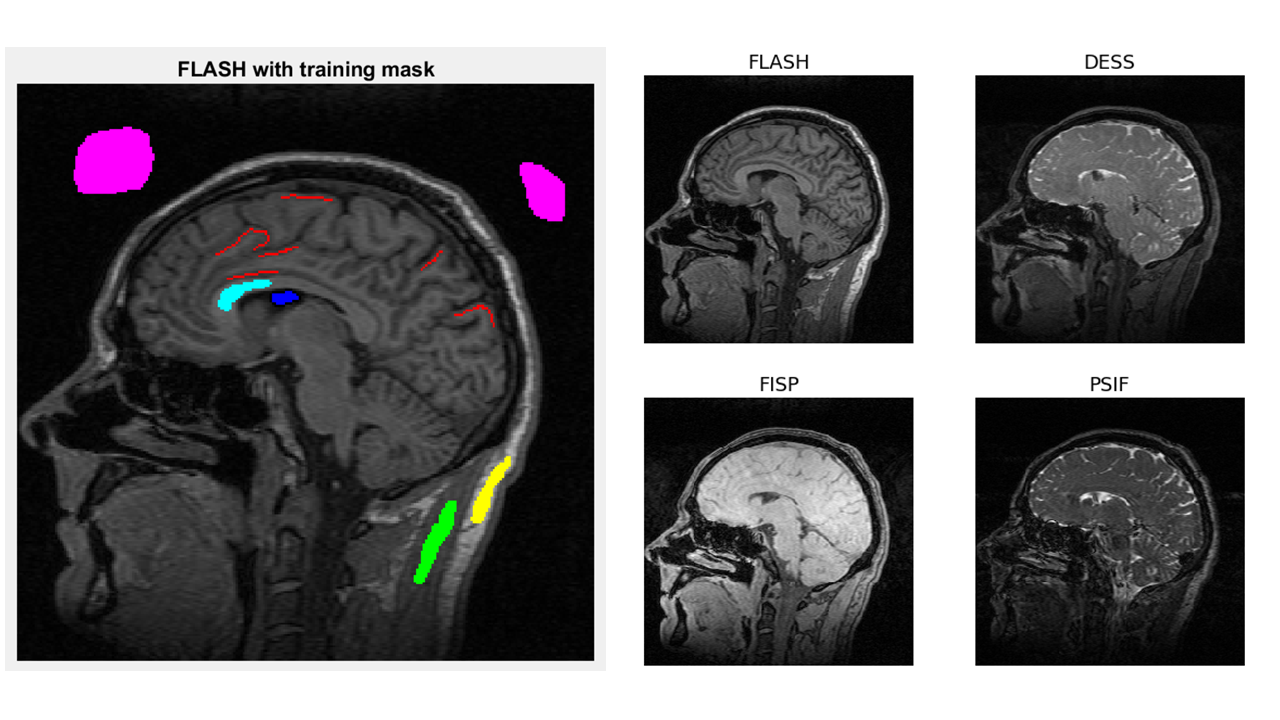

In [32]:
from IPython.display import Image
Image(filename='./assets/multispectral_tissue_classification_pptx.png', width=600)

 > **Your turn!** 
 >
 > - Which channel (pulse sequence) do you find having the overall best CNR? (zoom in on the four channel images)

**Import libraries to be used**

In [33]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

# Supress some warnings:
import warnings
warnings.filterwarnings('ignore')

import os
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import skimage
import IPython

home = os.path.expanduser('~')  # home is to make path to local home directory
#print('home: %s' % home)

**Define directories, channel names** (check: [MRI pulse sequences](https://radiopaedia.org/articles/mri-pulse-sequences-1)) **and class labels** (check: [tissue types](https://en.wikipedia.org/wiki/Tissue_(biology))) **being used**

[MRI pulse sequence abbrev.](https://radiopaedia.org/articles/mri-pulse-sequence-abbreviations):

 - FLASH - Fast Low Angle Shot [[ref](https://en.wikipedia.org/wiki/Fast_low_angle_shot_magnetic_resonance_imaging)]
 - DESS - Double Echo Steady State [[ref](http://mriquestions.com/dess.html)]
 - FISP - Fast Imaging with Steady-state free Precession [[ref](http://mriquestions.com/psif-vs-fisp.html)]
 - PSIF - reverse FISP

In [34]:
mydata = '../testdata'
chn_names = ['FLASH', 'DESS', 'FISP', 'PSIF']
class_names = ['air', 'gm', 'wm', 'csf', 'mus', 'fat']

## Construct a multispectral image

**Initialize and read gnu-zipped [NIFTI](https://nifti.nimh.nih.gov)-files ( .nii.gz) looping through the list of channel images**

In [35]:
k=1
images = []  # for making a sequence of channel images
for fn in chn_names:
    cmd = 'img%d = nib.load("%s/%s_060.nii.gz")' % (k, mydata, fn.lower())
    exec(cmd)
    print(cmd)
    cmd = 'images.append(img%d)' % (k); exec(cmd)
    k=k+1

img1 = nib.load("../testdata/flash_060.nii.gz")
img2 = nib.load("../testdata/dess_060.nii.gz")
img3 = nib.load("../testdata/fisp_060.nii.gz")
img4 = nib.load("../testdata/psif_060.nii.gz")


An alternative import of NIFTI images (a "one-liner"):

In [36]:
images = [nib.load(f'../testdata/{channel.lower()}_060.nii.gz') for channel in chn_names]
print('Number of images:', len(images))

Number of images: 4


**Using `nibabel` [concat_images](http://nipy.org/nibabel/reference/nibabel.funcs.html#nibabel.funcs.concat_images) to construct a multispectral image from $k$ channel images having the same $n \times n$ image matrix**

In [37]:
# Concatenate images
img_mult = nib.concat_images(images)

**Display the affine matrix and the FLASH slice image using [`OrthoSlicer3D`](https://nipy.org/nibabel/reference/nibabel.viewers.html)**

Affine matrix (geometry/orientation):
 [[   0.            0.            1.39999998    0.        ]
 [  -1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


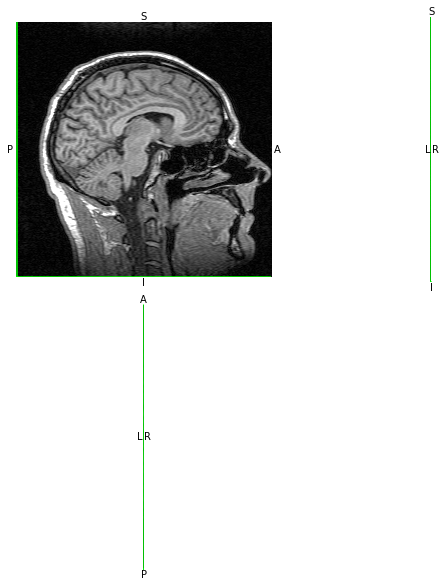

In [38]:
from nibabel.viewers import OrthoSlicer3D
print('Affine matrix (geometry/orientation):\n', img1.affine)
OrthoSlicer3D(images[0].get_data(), affine = images[0].affine).show()

> **CHECK OUT:** 
>
> - *Coordinate systems and affine transformations in medical imaging (e.g. [nibabel](http://nipy.org/nibabel/coordinate_systems.html) / [nilearn](http://nilearn.github.io/auto_examples/04_manipulating_images/plot_affine_transformation.html))*
> - *Converting images in  DICOM-format (from the scanner) to NIFTI-format for processing (e.g. [dcm2nii](https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage) and [dcm2niix](https://github.com/rordenlab/dcm2niix))*

In our case you will perform a reflexion along the x-axis, i.e. change sign of the corresponding element in the affine $4 \times 4$ matrix, do:

In [39]:
aff = img_mult.affine
print('aff original:\n', aff)
aff_new = aff.copy()
aff_new[1][0]=1  # Change sign
print('\n aff_new:\n', aff_new)
img = nib.Nifti1Pair(img_mult.get_data(), aff_new)
print('\n img.affine:\n', img.affine)

aff original:
 [[   0.            0.            1.39999998    0.        ]
 [  -1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]

 aff_new:
 [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]

 img.affine:
 [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


Check the new spatial orientation after changing sign corresponding to the x-direction represented in the affine matrix: 

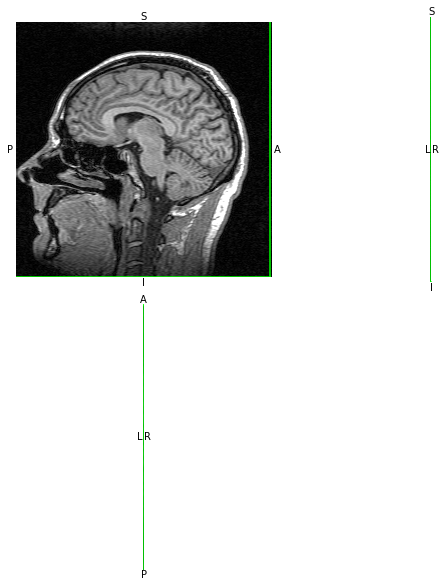

In [40]:
img1_ap = nib.Nifti1Pair(img1.get_data(), aff_new)
OrthoSlicer3D(images[0].get_data(), affine = aff_new).show()

> **Your turn!**
>
> - Design an affine matrix `aff_upd` that turns the image upside down and display the result

> Hint:
```python
aff_upd = aff.copy()
aff_upd[2][1]=-1  # Change sign
OrthoSlicer3D(images[0].get_data(), affine = aff_upd).show()
```

In [41]:
# Your code:

**Save the multispectral image to the local directory `data/BRAIN-MRI`**

In [42]:
fn_multispectral = '../data/BRAIN-MRI/multispectral_mri.nii.gz'
nib.save(img, fn_multispectral)

**Show characteristics of the multispectral NIFTI image**

In [43]:
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
data = img.get_data()
print('min = %.1f' % data.min())
print('max = %.1f' % data.max())
print('number of channels =', img.shape[-1])
# Collaps the singular (z-)dimension
dat = np.uint16(data.squeeze())
print('shape of 2D+spectral dat = ',dat.shape)
print('dtype of 2D+spectral dat = ',dat.dtype)

shape of image =  (256, 256, 1, 4)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = float64
min = 0.0
max = 493.0
number of channels = 4
shape of 2D+spectral dat =  (256, 256, 4)
dtype of 2D+spectral dat =  uint16


**Display image data of the various channels in the multispectral image**

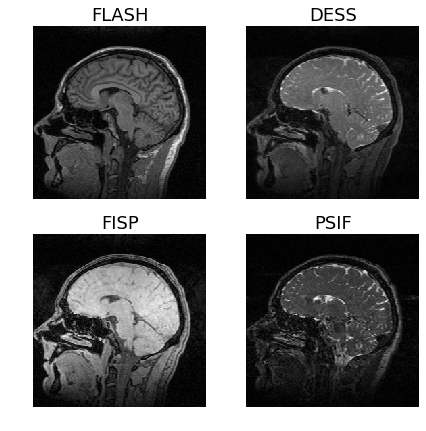

In [44]:
fig = plt.figure('Showing the multispectral image', figsize = [7, 7])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title(chn_names[0], fontsize=18)
plt.imshow(dat[:, :, 0].T, cmap='gray', origin='lower')  # .T for transpose to correct orientation
plt.subplot(2, 2, 2).set_axis_off(), plt.title(chn_names[1], fontsize=18)
plt.imshow(dat[:, :, 1].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title(chn_names[2], fontsize=18)
plt.imshow(dat[:, :, 2].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title(chn_names[3], fontsize=18)
plt.imshow(dat[:, :, 3].T, cmap='gray', origin='lower')
plt.show()

#fig.savefig('%s/prj/Seili-2019/results/flash_dess_fisp_psif_channel_images.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

## Noise in the (MR) image - analyze noise, add noise

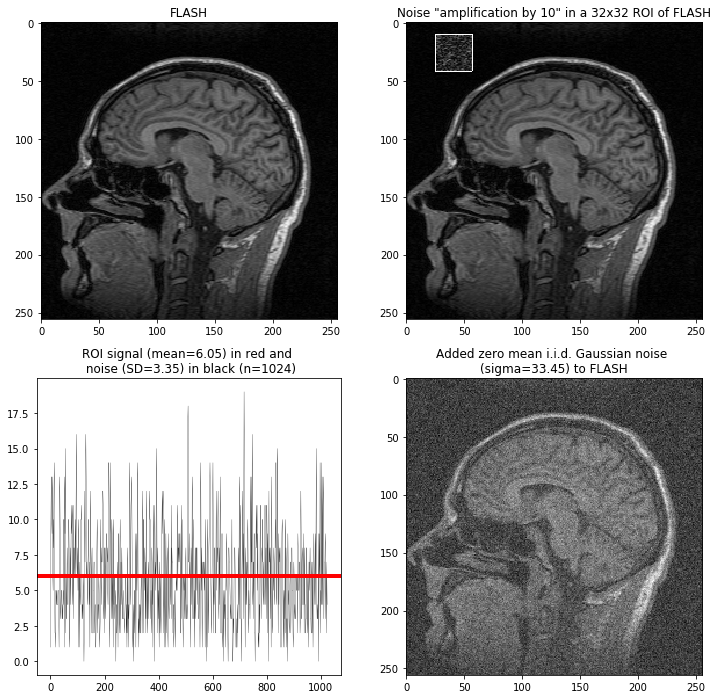

In [45]:
# Define a quadratic ROI
r = 10 # row
c = 25 # col
d = 32 # side-length
a = 10 # amplification factor

# Read the previously saved multispactral nifiti image
img = nib.load(fn_multispectral)
data = img.get_data()
flash_data = np.flip(data[:, :, :, 0].squeeze().T, 0)
mx = flash_data.max()

flash_data_upper_left = flash_data.copy()
flash_data_upper_left[r:r+d, c:c+d] = a*flash_data[r:r+d, c:c+d]

roi_bck = flash_data[r:r+d, c:c+d].flatten()
roi_mean = roi_bck.mean()
roi_std = roi_bck.std()

flash_data_upper_left[r, c:c+d] = mx
flash_data_upper_left[r+d, c:c+d] = mx
flash_data_upper_left[r:r+d, c] = mx
flash_data_upper_left[r:r+d, c+d] = mx

# Define characteristics of noisy image
mean = 0.0          # zero mean
std = a*roi_std     # noise standard deviation amplification
noisy_flash = flash_data + np.random.normal(mean, std, flash_data.shape)


fig = plt.figure(figsize = [12, 12])
plt.subplot(2,2,1)
plt.imshow(flash_data, cmap='gray')
plt.title('FLASH')
plt.subplot(2,2,2)
plt.imshow(flash_data_upper_left, cmap='gray' )
plt.title('Noise "amplification by %d" in a %dx%d ROI of FLASH' % (a, d, d))
plt.subplot(2,2,3)
plt.plot(roi_bck, linewidth=0.25, color='k')
plt.axhline(y=roi_mean, linewidth=4, color='r')
plt.title('ROI signal (mean=%.2f) in red and \n noise (SD=%.2f) in black (n=%d)' % (roi_mean, roi_std, d*d))
plt.subplot(2,2,4)
plt.imshow(noisy_flash, cmap='gray' )
plt.title('Added zero mean i.i.d. Gaussian noise \n(sigma=%.2f) to FLASH' % (std))

plt.show()

#fig.savefig('%s/prj/Seili-2019/results/flash_and_additive_zero_mean_iid_gaussian_noise.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

## Read training mask and ROI mask

In [46]:
fn_train = '%s/flash_060_training_mask_6cla.png' % (mydata)
fn_roi = '%s/flash_060_brain_mask.png' % (mydata)

**Read .png files using Matplotlib**
`?plt.imread`

In [47]:
train_msk = plt.imread(fn_train)
roi_msk = plt.imread(fn_roi)

print('train_msk.dtype:', train_msk.dtype)
print('roi_msk.dtype:', roi_msk.dtype)
print('train_msk.shape:', train_msk.shape)
print('roi_msk.shape:', roi_msk.shape)
print('train_msk.min , max:', train_msk.min(), ',', train_msk.max())

train_msk.dtype: float32
roi_msk.dtype: float32
train_msk.shape: (256, 256, 3)
roi_msk.shape: (256, 256, 3)
train_msk.min , max: 0.0 , 1.0


**Scale the mask images to uint8 RGB images, i.e. R,G,B $\in$ {0,...,255}**

In [48]:
train_msk = np.uint8(train_msk*255.0)
roi_msk = np.uint8(roi_msk*255.0)
print('train_msk.min:', train_msk.min(), ',', 'train_msk.max:', train_msk.max())

train_msk.min: 0 , train_msk.max: 255


**Display training mask and ROI mask (mask that covers the region of interest)**<br>

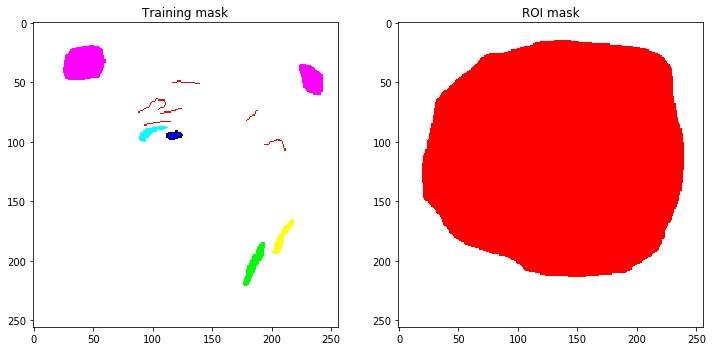

In [49]:
fig = plt.figure('Showing the training mask and the ROI mask', figsize = [12, 7])
plt.subplot(1,2,1)
plt.imshow(train_msk)
plt.title('Training mask')
plt.subplot(1,2,2)
plt.imshow(roi_msk)
plt.title('ROI mask')
plt.show()

**Print the RGB-values in the middle of the ROI mask (excpected to be red)**

In [50]:
row = np.uint8(np.ceil(roi_msk.shape[0]/2))  # row of target pixel location
col = np.uint8(np.ceil(roi_msk.shape[1]/2)) # column
v = roi_msk[row, col,:] # RGB-value at this pixel-location 
print('roi_msk[%d, %d,:] =' % (row, col)); print(v)

roi_msk[128, 128,:] =
[255   0   0]


**Make a new binary uint8 matrix ("targ") where we assign 0 (black) to all pixel locations outside the training mask and 1 (white) to all pixel locations for which a tissue type is labeled (target).**<br>
In the color-coded training mask white (=[255,255,255]) is used to represent background.<br>
We will employ `np.all` for this purpose, explained in more detail by writing `?np.all` in a code cell.

In [51]:
# ?np.all

In [52]:
targ = 1 - np.all(train_msk == [255,255,255], axis=2).astype(np.uint8)
targ_roi = 1 - np.all(roi_msk == [255,255,255], axis=2).astype(np.uint8)
print('train_msk.shape', train_msk.shape)
print('targ.shape', targ.shape)

train_msk.shape (256, 256, 3)
targ.shape (256, 256)


**Display color-coded training mask and corresponding binary masks for labelled pixels and ROI pixels, respectively**

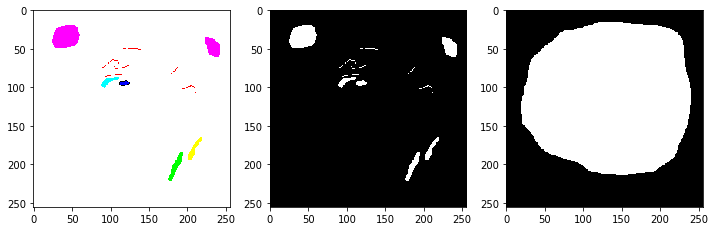

In [53]:
fig = plt.figure(figsize = [12, 7])
plt.subplot(1,3,1)
plt.imshow(train_msk)
plt.subplot(1,3,2)
plt.imshow(targ,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(targ_roi, cmap='gray')
plt.show()

**Compute number of pixel occurences for each distinct color (i.e. number of samples in each class) in the training in descending order**

In [54]:
from collections import Counter
Counter([tuple(colors) for i in train_msk for colors in i]).most_common()

[((255, 255, 255), 63519),
 ((255, 0, 255), 1250),
 ((0, 255, 0), 250),
 ((255, 255, 0), 170),
 ((255, 0, 0), 136),
 ((0, 255, 255), 129),
 ((0, 0, 255), 51),
 ((0, 0, 0), 31)]

**We can also display a grayscale training mask derived from the color-coded mask using OpenCV and the transformation COLOR_RGB2GRAY**

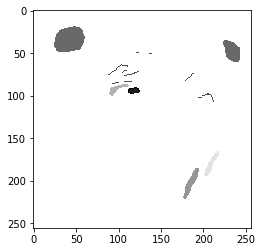

In [55]:
train_msk_grey = cv2.cvtColor(train_msk, cv2.COLOR_RGB2GRAY)
plt.imshow(train_msk_grey, cmap='gray')
plt.show()

**Compute number of pixel occurences for each gray level (i.e. number of pixels in each class) in the grayscale training mask in descending order**

In [56]:
a = train_msk_grey.flatten()
unique, counts = np.unique(a, return_counts=True)
d = dict(zip(unique, counts))
sorted_by_counts = sorted(d.items(), key=lambda v: v[1], reverse=True)  # by second element
sorted_by_counts

[(255, 63519),
 (105, 1250),
 (150, 250),
 (226, 170),
 (76, 136),
 (179, 129),
 (29, 51),
 (0, 31)]

**NOTE:** In the color-coding in the traing mask (and in the grayscale mask) the RGB value [0,0,0] and grayscale value 0, respectively are shown as black (in total 31 pixels) and do not correspond to any of the pre-defined classes. This is **an error in the manual labeling** of tissue types and should be mapped to background, i.e. [255,255,255] and 0, respectively.

> **Your turn!**
>
> - Find these errouneous assignments of pixels to black, diplay these, and make a corrected training mask where these pixels are assigned to background (white)<br>(as made implicitly further down in this notebook)

In [57]:
# Your code:

## Superimpose color-code mask on grayscale image

**Superimpose color-code training mask on the gray level FLASH channel image**<br>

Here using a "brute force" pixel loop  ...

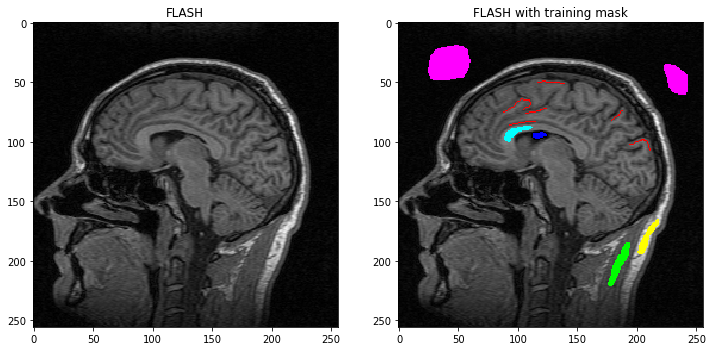

In [58]:
# Scale the intensity in FLASH to a maximum of mymax to keep data within a uint8 (0-255) range
mymax = 200
flash_channel = dat[:, :, 0].squeeze()   # dat[:,:,0] is the FLASH channel
flash_channel = np.flip(flash_channel.T, 0)  # This numpy matrix manipulation step is explained later
flash_max = mymax * (flash_channel/flash_channel.max())
nrow, ncol = flash_max.shape
r = min(flash_channel.max(), 255) / mymax  # Scaling for the superimposed gray-scale pixels

# Define the RGB / grey-level composite (overlay) uint8 image
# by returning a new array of given shape and type, filled with zeros
flash_train_rgb = np.zeros(shape=(nrow,ncol,3), dtype=np.uint8)

# Loop over all pixels (this is brute force)
for i in range(nrow):
    for j in range(ncol):
        # Check if pixel coordinate is member of a tissue mask (white)
        if (targ[i,j] == 1):
           # Keep the mask RGB color (using RGB values in {0,,,.255}) at this location         
            for k in range(3):
                flash_train_rgb[i,j,k] = train_msk[i,j,k]
        else:
            # Make a gray-level pixel according to the signal intensity in rescaled FLASH
            for k in range(3):
                flash_train_rgb[i,j,k] = np.uint8(np.ceil(flash_max[i,j]*r))
                
fig = plt.figure(figsize = [12, 7])
plt.subplot(1,2,1)
plt.imshow(flash_max, cmap='gray'), plt.title('FLASH')
plt.subplot(1,2,2)
plt.imshow(flash_train_rgb), plt.title('FLASH with training mask')
plt.show()

fig.savefig('%s/prj/Seili-2019/results/flash_with_training_mask_6_classes.png' % (home),
            transparent=False, dpi=300, bbox_inches="tight")

##  Find all pixles where the RGB tuples correspond to a given class

**Color-coding scheme used for manual labeling of pixels ( in the FLASH channel)** <br>
There exists different software packages and tools aimed for manual labeling, today a recommendd tool is  __[ITK-SNAP](http://www.itksnap.org)__.

In [59]:
AIR = [255,0,255] # Magenta 
GM  = [255,0,0]   # Red 
WM  = [0,255,255] # Cyan 
CSF = [0,0,255]   # Blue 
MUS = [0,255,0]   # Green 
FAT = [255,255,0] # Yellow 

ERR = [0,0,0] # Black
BCK = [255,255,255] # White (background)

One of several procedures: find all pixels for which training mask value is color-coded RGB class value for each of the classes

In [60]:
air = np.all(train_msk == AIR, axis=2).astype(np.int)
n_air = np.count_nonzero(air)
print('n_air =', n_air)

gm = np.all(train_msk == GM, axis=2).astype(np.int)
n_gm = np.count_nonzero(gm)
print('n_gm =', n_gm)

wm = np.all(train_msk == WM, axis=2).astype(np.int)
n_wm = np.count_nonzero(wm)
print('n_wm =', n_wm)

csf = np.all(train_msk == CSF, axis=2).astype(np.int)
n_csf = np.count_nonzero(csf)
print('n_csf =', n_csf)

mus = np.all(train_msk == MUS, axis=2).astype(np.int)
n_mus = np.count_nonzero(mus)
print('n_mus =', n_mus)

fat = np.all(train_msk == FAT, axis=2).astype(np.int)
n_fat = np.count_nonzero(fat)
print('n_fat =', n_fat)

err = np.all(train_msk == ERR, axis=2).astype(np.int)
n_err = np.count_nonzero(err)
print('\nn_err =', n_err)

bck = np.all(train_msk == BCK, axis=2).astype(np.int)
n_bck = np.count_nonzero(bck)
print('n_bck =', n_bck)

n_air = 1250
n_gm = 136
n_wm = 129
n_csf = 51
n_mus = 250
n_fat = 170

n_err = 31
n_bck = 63519


or a more compact solution - a (key, value) **dictionary**

In [61]:
col_code = {
    'AIR': [255,0,255],  # Magenta 
    'GM':  [255,0,0],    # Red 
    'WM':  [0,255,255],  # Cyan 
    'CSF': [0,0,255],    # Blue 
    'MUS': [0,255,0],    # Green 
    'FAT': [255,255,0],  # Yellow 
    'ERR': [0,0,0],      # Black
    'BCK': [255,255,255] # White (background)
}

Constructing strings of program command setences with specific parameters, and thereafter executing the command using e.g.  __[exec](https://www.geeksforgeeks.org/exec-in-python)__

In [62]:
# Make separate masks for each class

for key in col_code.keys():
    keyl = key.lower()
    cmd1 = '%s = np.int16(np.all(train_msk == %s, axis=2))' % (keyl, key); exec(cmd1)
    cmd2 = 'n_%s = np.count_nonzero(%s)' % (keyl, keyl); exec(cmd2)
    cmd3 = 'print("n_%s =", n_%s)' % (keyl, keyl); exec(cmd3)

n_air = 1250
n_gm = 136
n_wm = 129
n_csf = 51
n_mus = 250
n_fat = 170
n_err = 31
n_bck = 63519


Alternatively, use Numpy's __[where](https://stackoverflow.com/questions/34667282/numpy-where-detailed-step-by-step-explanation-examples)__ to make
**a composite gray level training mask according to the class enumbering**<br>
 AIR=1, GM=2, WM=3, CSF=4, MUS=5, FAT=6

In [63]:
# Using np.where() to find pixel locations for each class of the 6 valid tissue types
col_code_sub = {a: col_code[a] for a in ['AIR','GM','WM', 'CSF', 'MUS', 'FAT'] if a in col_code}
cc = list(col_code_sub.keys())
train_msk_1_6 = np.zeros(train_msk[:,:,0].shape, dtype=np.uint8)  # Initialize with background zero
for n, val in enumerate(col_code_sub.values()):
    m = cc[n].lower()
    mm = np.where((train_msk[:,:,0] == val[0]) & (train_msk[:,:,1] == val[1]) & (train_msk[:,:,2] == val[2]))
    train_msk_1_6[mm[0],mm[1]] = (n+1)  # # mm[0]: rows, mm[1]: cols
    print('cla_%d (%s) n=%d %d' % (n+1, m , len(mm[0]), np.count_nonzero(train_msk_1_6)))

cla_1 (air) n=1250 1250
cla_2 (gm) n=136 1386
cla_3 (wm) n=129 1515
cla_4 (csf) n=51 1566
cla_5 (mus) n=250 1816
cla_6 (fat) n=170 1986


Total number of training pixels: 1986


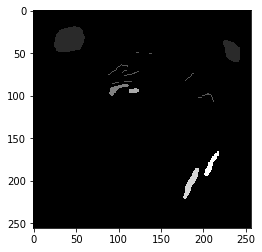

In [64]:
#train_msk_1_6 = 1*air + 2*gm + 3*wm + 4*csf + 5*mus + 6*fat
plt.imshow(train_msk_1_6, cmap='gray')
print('Total number of training pixels: %d' % np.count_nonzero(train_msk_1_6))
plt.show()

**Check class distribution  - which is unbalanced (see e.g. [Brownlee](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset) og [`imbalanced-learn`](https://github.com/scikit-learn-contrib/imbalanced-learn/blob/master/README.rst))**

In [65]:
a = train_msk_1_6.flatten()
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{0: 63550, 1: 1250, 2: 136, 3: 129, 4: 51, 5: 250, 6: 170}

**Save `training_mask_1_6` as int16 NIFTI image and use header information (affine) from the multispectral image**

In [66]:
fn_tmsk = '../data/BRAIN-MRI/training_mask_1_6.nii.gz'
# We have to flip and transpose to align the mask to the multispectral image
training_mask_1_6 = np.flip(train_msk_1_6, 0).T 
# and make a 4-dim matrix with z-dim and spectral-dim both =1 to match the mult
nrow = training_mask_1_6.shape[0]
ncol = training_mask_1_6.shape[1]
training_mask_1_6 = np.reshape(training_mask_1_6, (nrow, ncol, 1, 1))
tmsk = nib.Nifti1Image(np.int16(training_mask_1_6), img.affine )
nib.save(tmsk, fn_tmsk)

**Check  results!** (e.g. using FreeSurfer's [freeview](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/OutputData_freeview))

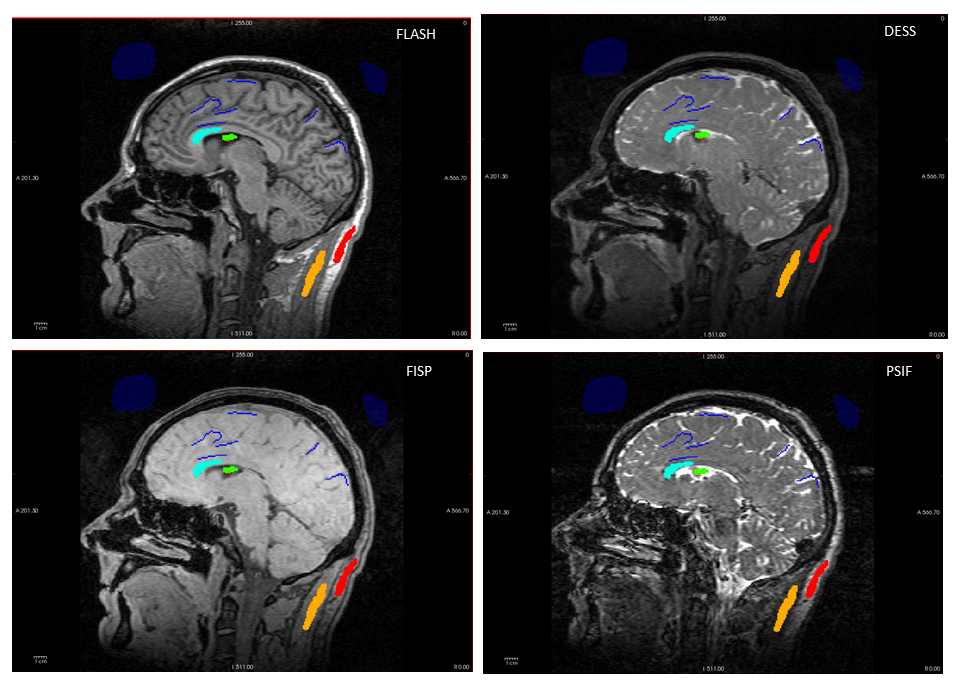

In [67]:
from IPython.display import Image
Image(filename='./assets/tmsk_on_channels_freeview_pptx.png', width=700)

or using nilearn's [plotting](http://nilearn.github.io/plotting)

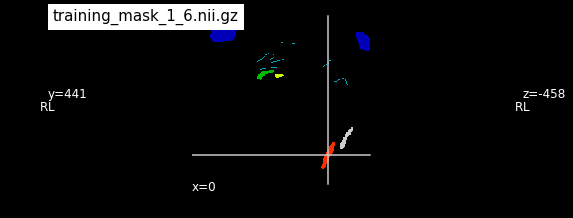

In [68]:
plotting.plot_epi(fn_tmsk, title='training_mask_1_6.nii.gz')
plt.show()

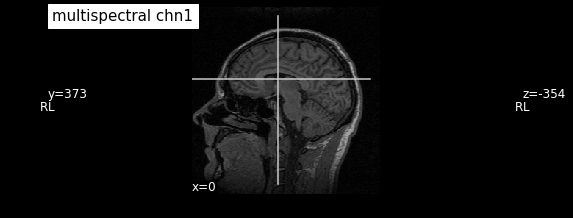

In [69]:
plotting.plot_anat(img1_ap, title="multispectral chn1")
plt.show()

**Save `brain_roi_mask` as int16 NIFTI image and apply header information (affine) from the multispectral image**

In [70]:
fn_roi = '../data/BRAIN-MRI/brain_roi_mask.nii.gz'
#roi = np.all(roi_msk == [255,0,0], axis=1).astype(np.int)
#n_roi = np.count_nonzero(roi)
#print('n_roi =', n_roi)
# We have to flip and transpose to align the mask to the multispectral image
trag_roi = np.flip(targ_roi, 0).T 
# and make a 4-dim matrix with z-dim and spectral-dim both =1 to match the mult
nrow = targ_roi.shape[0]
ncol = targ_roi.shape[1]
targ_roi = np.reshape(trag_roi, (nrow, ncol, 1, 1))
rmsk = nib.Nifti1Image(np.int16(targ_roi), img.affine )
nib.save(rmsk, fn_roi)

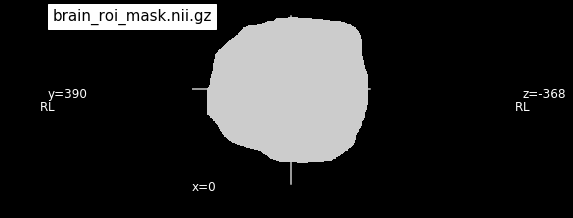

In [71]:
plotting.plot_epi(fn_roi, title='brain_roi_mask.nii.gz')
plt.show()

**Display labelled pixels for each of the six classes as separat binary masks**

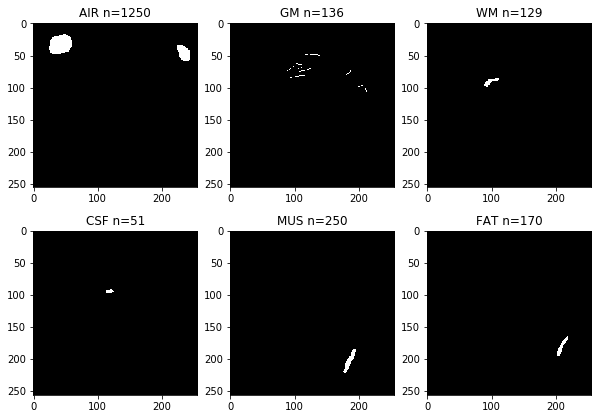

In [72]:
fig = plt.figure('Showing the training masks', figsize = [10, 7])
plt.tight_layout
fonts = 12
plt.subplot(2,3,1), plt.title('AIR n=%d' % (n_air), fontsize=fonts)
plt.imshow(air, cmap='gray')
plt.subplot(2,3,2), plt.title('GM n=%d' % (n_gm), fontsize=fonts)
plt.imshow(gm, cmap='gray')
plt.subplot(2,3,3), plt.title('WM n=%d' % (n_wm), fontsize=fonts)
plt.imshow(wm, cmap='gray')
plt.subplot(2,3,4), plt.title('CSF n=%d' % (n_csf), fontsize=fonts)
plt.imshow(csf, cmap='gray')
plt.subplot(2,3,5), plt.title('MUS n=%d' % (n_mus), fontsize=fonts)
plt.imshow(mus, cmap='gray')
plt.subplot(2,3,6), plt.title('FAT n=%d' % (n_fat), fontsize=fonts)
plt.imshow(fat, cmap='gray')
plt.show()

## Find tissue type and sequence-specific MRI signal intensities 

In [73]:
# Get data for each 2D channel image
p = len(chn_names)
flash_chn_dat = dat[:, :, 0].squeeze()
dess_chn_dat = dat[:, :, 1].squeeze()
fisp_chn_dat = dat[:, :, 2].squeeze()
psif_chn_dat = dat[:, :, 3].squeeze()

**NB! Check your data (correct image orientation and geometric correspondence between training mask and pixel values - i.e. the image data!)**

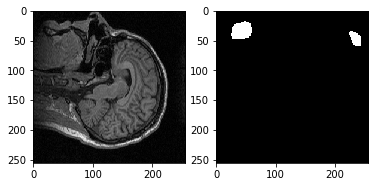

In [74]:
plt.subplot(1,2,1)
plt.imshow(flash_chn_dat, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(air, cmap='gray')
plt.show()

**We will need to transpose the channel image and flip the image matrix vertically**

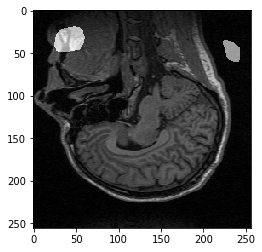

In [75]:
plt.imshow(flash_chn_dat.T + 255*air, cmap='gray')
plt.show()

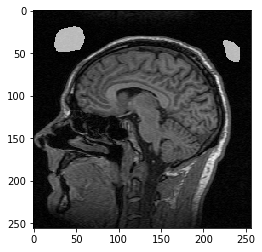

In [76]:
%matplotlib inline
plt.imshow(np.flip(flash_chn_dat.T, 0) + 255*air, cmap='gray')
plt.show()

In [77]:
flash_chn = np.flip(flash_chn_dat.T, 0)
dess_chn = np.flip(dess_chn_dat.T, 0)
fisp_chn = np.flip(fisp_chn_dat.T, 0)
psif_chn = np.flip(psif_chn_dat.T, 0)

**Design a function that defines class-specific p-dimensional feature matrix (data matrix)  <br> for a given class k $\in$ {air, gm, wm, csf, mus, fat}** 

In [78]:
def make_feature_matrix(k):
    '''
    Ex.
    A = make_feature_matrix(air)
    A.shape
    '''
    M = np.column_stack(
        (flash_chn[k == 1], 
         dess_chn[k == 1],
         fisp_chn[k == 1],
         psif_chn[k == 1]))
    return M

A = make_feature_matrix(air)
print('Noise in FLASH: %.2f (n=%d)' % (A[:,0].std(), A.shape[0]))
print('Noise in DESS : %.2f (n=%d)' % (A[:,1].std(), A.shape[0]))
print('Noise in FSIP : %.2f (n=%d)' % (A[:,2].std(), A.shape[0]))
print('Noise in PSIF : %.2f (n=%d)' % (A[:,3].std(), A.shape[0]))

Noise in FLASH: 3.47 (n=1250)
Noise in DESS : 4.88 (n=1250)
Noise in FSIP : 4.47 (n=1250)
Noise in PSIF : 3.44 (n=1250)


**This function will be used to make class-specific pandas dataframes where features are <br> MRI signal intensities (SI) in each of the channels of the multispectral image** 

In [79]:
dfAIR = pd.DataFrame(make_feature_matrix(air), columns = chn_names)
dfAIR.insert(p, 'Class', 'AIR')
dfAIR.head(3)

,FLASH,DESS,FISP,PSIF,Class
0,5,6,2,2,AIR
1,5,6,4,10,AIR
2,2,5,2,9,AIR


In [80]:
dfGM = pd.DataFrame(make_feature_matrix(gm),  columns = chn_names)
dfGM.insert(p, 'Class', 'GM')

In [81]:
dfWM = pd.DataFrame(make_feature_matrix(wm),  columns = chn_names)
dfWM.insert(p, 'Class', 'WM')

In [82]:
dfCSF = pd.DataFrame(make_feature_matrix(csf),  columns = chn_names)
dfCSF.insert(p, 'Class', 'CSF')

In [83]:
dfMUS = pd.DataFrame(make_feature_matrix(mus),  columns = chn_names)
dfMUS.insert(p, 'Class', 'MUS')

In [84]:
dfFAT = pd.DataFrame(make_feature_matrix(fat),  columns = chn_names)
dfFAT.insert(p, 'Class', 'FAT')
dfFAT.tail(3)

,FLASH,DESS,FISP,PSIF,Class
167,229,34,112,135,FAT
168,235,32,117,159,FAT
169,251,31,125,172,FAT


**Concatenate the tissue-specific data frames to a complete training dataset (dfT), and save the result as a csv-file in the data/mri directory**

In [85]:
frames = [dfAIR, dfGM, dfWM, dfCSF, dfMUS, dfFAT]
dfT = pd.concat(frames, ignore_index=True)
dfT.to_csv('../data/BRAIN-MRI/multispectral_mri_training_data.csv', index=False)
dfT.head(3)

,FLASH,DESS,FISP,PSIF,Class
0,5,6,2,2,AIR
1,5,6,4,10,AIR
2,2,5,2,9,AIR


In [86]:
dfT.tail(3)

,FLASH,DESS,FISP,PSIF,Class
1983,229,34,112,135,FAT
1984,235,32,117,159,FAT
1985,251,31,125,172,FAT


## Explorative Data Analysis (EDA) 
**Descriptive statistics & graphics**

In [87]:
# Make a list of the different class-labels in the training dataset
dfT['Class'].unique().tolist()

['AIR', 'GM', 'WM', 'CSF', 'MUS', 'FAT']

In [88]:
# Class-specific statistics accross the different features (channels)
dfT.groupby('Class').describe(percentiles = [0.5]).round(2).T

Class            AIR     CSF     FAT      GM     MUS      WM
FLASH count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.05   29.20  264.44  112.73  101.34  162.72
      std       3.47    6.67   40.78   11.18    8.81    6.87
      min       0.00   13.00  140.00   91.00   79.00  132.00
      50%       6.00   30.00  271.00  112.00  103.00  163.00
      max      19.00   46.00  338.00  152.00  123.00  178.00
DESS  count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.92  129.29   45.18  127.43   50.77  117.88
      std       4.88   70.86    9.18   19.70    7.18    6.72
      min       0.00   42.00   24.00  100.00   28.00  101.00
      50%       6.00  110.00   45.00  124.50   51.00  118.00
      max      26.00  258.00   71.00  217.00   70.00  137.00
FISP  count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.55   71.04  133.69  171.60  103.37  187.75
      std       4.47   12.17   25.82   16.72   21.55    8.11
      min       0.00   50.00   72.00  127.00   34.00  174.00
      50%       5.00   70.00  135.00  172.00  102.00  187.00
      max      26.00   99.00  185.00  221.00  144.00  209.00
PSIF  count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.00  285.41  152.31  154.75   45.33  112.36
      std       3.45  104.92   28.73   68.43   12.10   18.02
      min       0.00  104.00   68.00  103.00   19.00   66.00
      50%       6.00  324.00  154.00  126.00   45.00  113.00
      max      19.00  418.00  214.00  439.00   78.00  168.00

**Class-wise boxplot for each feature (channel)**

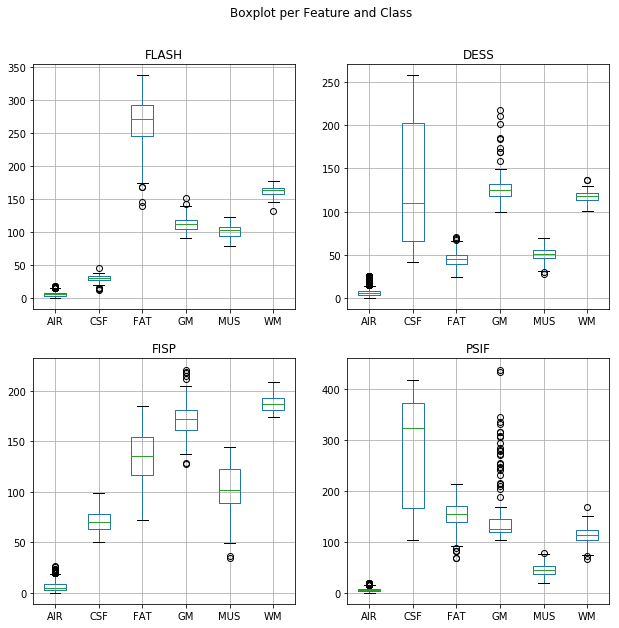

In [89]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    dfT.boxplot(column=[ch], by='Class', ax=ax[k])
    ax[k].set_title(ch.upper())
    ax[k].set(xlabel="")
plt.suptitle("Boxplot per Feature and Class")    
plt.show()

**Seaborn pairplot  - class-wise for each pair of of channels**

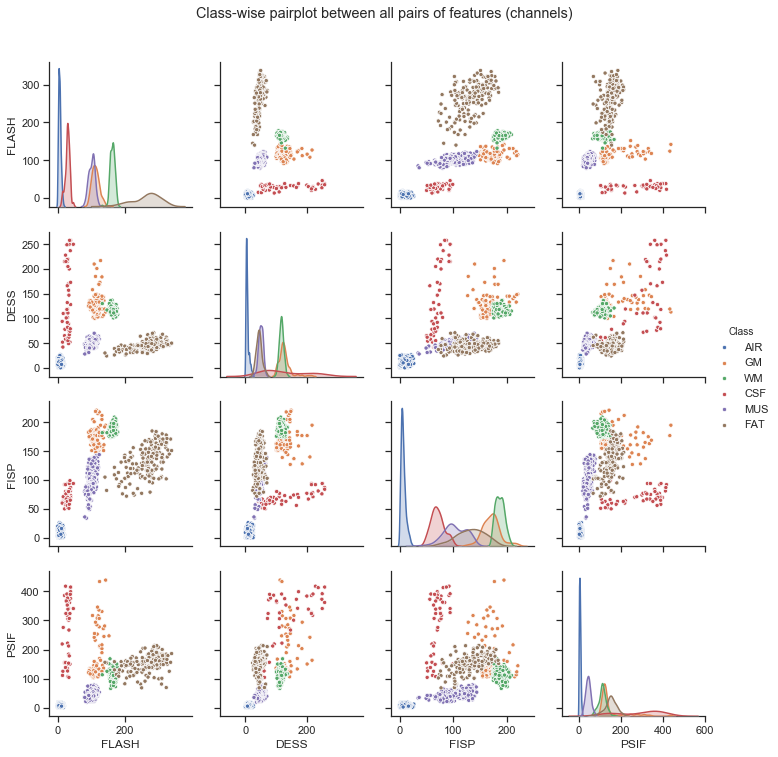

In [90]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(dfT, hue="Class", vars = chn_names, plot_kws = {"size":10})
g.fig.suptitle("Class-wise pairplot between all pairs of features (channels)", y=1.05) 
plt.show()

#g.savefig('%s/prj/Seili-2019/results/class_wise_pairplot_between_all_pairs_of_features_(channels).png' % (home),
#           transparent=False, dpi=300, bbox_inches="tight")

**Make a figure of tissue-specific SI-distributions (probability densities) for each of the channels**

In [91]:
# Find global SI min and max for each channel across all tissue types for same x-scaling
mn1 = dfT['FLASH'].min(); mx1 = dfT['FLASH'].max() 
mn2 = dfT['DESS'].min(); mx2 = dfT['DESS'].max() 
mn3 = dfT['FISP'].min(); mx3 = dfT['FISP'].max() 
mn4 = dfT['PSIF'].min(); mx4 = dfT['PSIF'].max() 

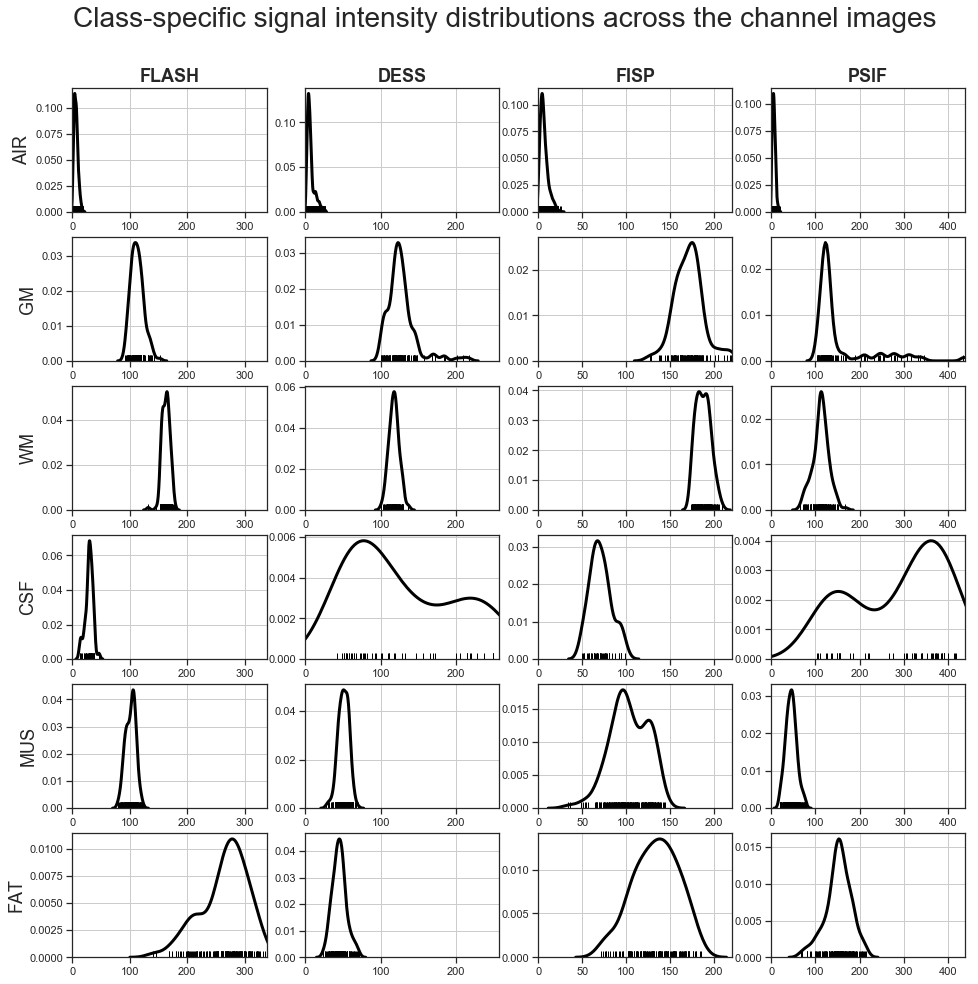

In [92]:
# Make the 6 x 4 panels in the figure
fig, axes = plt.subplots(6, 4, figsize=(16, 16), sharex=False, sharey=False)
fig.suptitle("Class-specific signal intensity distributions across the channel images", 
             fontsize=28, y=0.95)   # y location of the text in figure coordinates

for k, cla in enumerate(class_names):
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].FLASH.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,0])
    axes[k,0].set_xlim(mn1,mx1); axes[k,0].grid(True)
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].DESS.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,1])
    axes[k,1].set_xlim(mn2,mx2); axes[k,1].grid(True)
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].FISP.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,2])
    axes[k,2].set_xlim(mn3,mx3); axes[k,2].grid(True)
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].PSIF.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,3])
    axes[k,3].set_xlim(mn4,mx4); axes[k,3].grid(True)

# Make proper labels for the channel columns
for ch, chn in enumerate(chn_names):
    axes[0,ch].set_title(chn.upper(), fontsize=18, fontweight="bold")

# Make proper labels for the tissue type row-names
for k, cla in enumerate(class_names):
    axes[k,0].set(ylabel= cla.upper())
    axes[k,0].yaxis.label.set_size(18)

plt.show()

#fig.savefig('%s/prj/Seili-2019/results/class_specific_si_densities_across_channels.pdf' % (home))

#fig.savefig('%s/prj/Seili-2019/results/class_specific_si_densities_across_channels.png' % (home),
#           transparent=False, dpi=300, bbox_inches="tight")

**Make an interactive 3D scatterplot (do not work with Jupyter Lab)**

Define the combinations of classes and channels that can be used

In [93]:
x1air = list(dfT.loc[dfT['Class']=='AIR'].FLASH.values)
x2air = list(dfT.loc[dfT['Class']=='AIR'].DESS.values)
x3air = list(dfT.loc[dfT['Class']=='AIR'].FISP.values)

x1gm = list(dfT.loc[dfT['Class']=='GM'].FLASH.values)
x2gm = list(dfT.loc[dfT['Class']=='GM'].DESS.values)
x3gm = list(dfT.loc[dfT['Class']=='GM'].FISP.values)

x1wm = list(dfT.loc[dfT['Class']=='WM'].FLASH.values)
x2wm = list(dfT.loc[dfT['Class']=='WM'].DESS.values)
x3wm = list(dfT.loc[dfT['Class']=='WM'].FISP.values)

x1csf = list(dfT.loc[dfT['Class']=='CSF'].FLASH.values)
x2csf = list(dfT.loc[dfT['Class']=='CSF'].DESS.values)
x3csf = list(dfT.loc[dfT['Class']=='CSF'].FISP.values)

x1mus = list(dfT.loc[dfT['Class']=='MUS'].FLASH.values)
x2mus = list(dfT.loc[dfT['Class']=='MUS'].DESS.values)
x3mus = list(dfT.loc[dfT['Class']=='MUS'].FISP.values)

x1fat = list(dfT.loc[dfT['Class']=='FAT'].FLASH.values)
x2fat = list(dfT.loc[dfT['Class']=='FAT'].DESS.values)
x3fat = list(dfT.loc[dfT['Class']=='FAT'].FISP.values)

Make a 3D scatterplot (can not be interactive using Jupyter Lab) - issues on [`%matplotlib notebook`](https://stackoverflow.com/questions/43545050/using-matplotlib-notebook-after-matplotlib-inline-in-jupyter-notebook-doesnt)

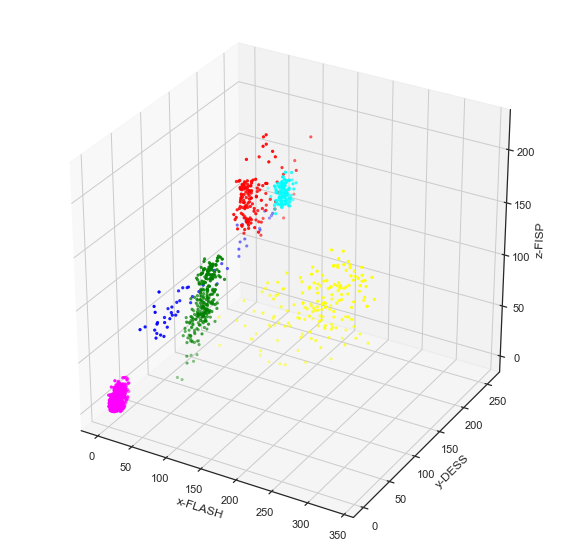

In [94]:
# Enables interactive 3D plot
# %matplotlib notebook 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# AIR = [255,0,255] # Magenta 
# GM  = [255,0,0]   # Red 
# WM  = [0,255,255] # Cyan 
# CSF = [0,0,255]   # Blue 
# MUS = [0,255,0]   # Green 
# FAT = [255,255,0] # Yellow 


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1air, x2air, x3air, c='magenta', marker='.')
ax.scatter(x1gm, x2gm, x3gm, c='red', marker='.')
ax.scatter(x1wm, x2wm, x3wm, c='cyan', marker='.')
ax.scatter(x1csf, x2csf, x3csf, c='blue', marker='.')
ax.scatter(x1mus, x2mus, x3mus, c='green', marker='.')
ax.scatter(x1fat, x2fat, x3fat, c='yellow', marker='.')

ax.set_xlabel('x-FLASH')
ax.set_ylabel('y-DESS')
ax.set_zlabel('z-FISP')

plt.show()

## Contrast-to-noise (CNR) in MR images

 - **Based on the tissue-specific signal intensity distributions for each of the MRI sequnces (channels) shown in the figures above, discuss:** 

    1.  Which channel will best discriminate / separate between GM and WM? 

    2.  Is it easy to distinguish between  `gray matter` and `muscle` in the FLASH channel?

    3.  Why do we find such a large variation in CSF signal intensites in the T2-weighted DESS channel?<br> 
  (hint: https://www.ajronline.org/doi/10.2214/AJR.05.0003)

 - **Write your results (graphs, tables, fugures) to a local directory on your computer** <br>
 
   (hint: make a folder outside your Git repository , e.g. $HOME/prj/Seili-2019/results, and add the following statement
   in the cell above, showing tissue-specific SI distributions (probability densities) for each of the channels: 
   
   ```python
   import os
   home = os.path.expanduser('~')
   
   fig.savefig('%s/prj/Seili-2019/results/class_specific_si_densities_across_channels.png' % (home), transparent=False, dpi=80, bbox_inches="tight")
   ```

   Moreover, save figures previously produced that illustrate data and results, in the same folder, i.e.
   
   ```python
   fig.savefig('%s/prj/Seili-2019/results/flash_dess_fisp_psif_channel_images.png' % (home),
   transparent=False, dpi=300, bbox_inches="tight")
   ```
   and
   ```python
   fig.savefig('%s/prj/Seili-2019/results/flash_with_training_mask_6_classes.png' % (home),
   transparent=False, dpi=300, bbox_inches="tight")
   ```   

- **Make a contrast-to-noise-ratio (CNR) tabel (dataframe) between each pair of tissue types and for each of the channels** <br>

     - Hint: We define the CNR between tissue type GM and tissue type WM in channel FLASH as: 
  
> CNR(GM,WM)$_{FLASH}$  =  abs(mean(GM)$_{FLASH}$ - mean(WM)$_{FLASH}$) / std(AIR)$_{FLASH}$

- Hint to compute the noise accross the set of channels:

```python
D = pd.read_csv('../data/BRAIN-MRI/multispectral_mri_training_data.csv')

sigma_0 = np.zeros(len(chn_names))
for k, chn in enumerate(chn_names):
    sigma_0[k] = np.std(list(D.loc[D['Class']=='AIR'][chn].values)).round(3)

list(sigma_0)
```

- Hint to compute CNR(tissue_a, tissue_b, channel_chn) as a function: 

```python
def cnr(a,b,chn):
    s_0 = np.std(list(D.loc[D['Class']=='AIR'][chn].values))
    mu_a = np.mean(list(D.loc[D['Class']==a][chn].values))
    mu_b = np.mean(list(D.loc[D['Class']==b][chn].values))
    cnr_a_b = abs(mu_a - mu_b)/ s_0
    return cnr_a_b

cnr('AIR','GM','FLASH').round(2)
```

In [95]:
# The code:

import os
home = os.path.expanduser('~')

fig.savefig('%s/prj/Seili-2019/results/class_specific_si_densities_across_channels.png' % (home), transparent=False, dpi=80, bbox_inches="tight")
fig.savefig('%s/prj/Seili-2019/results/flash_dess_fisp_psif_channel_images.png' % (home),
transparent=False, dpi=300, bbox_inches="tight")
fig.savefig('%s/prj/Seili-2019/results/flash_with_training_mask_6_classes.png' % (home),
transparent=False, dpi=300, bbox_inches="tight")

D = pd.read_csv('../data/BRAIN-MRI/multispectral_mri_training_data.csv')
sigma_0 = np.zeros(len(chn_names))
for k, chn in enumerate(chn_names):
    sigma_0[k] = np.std(list(D.loc[D['Class']=='AIR'][chn].values)).round(3)
print(list(sigma_0))

def cnr(a,b,chn):
    s_0 = np.std(list(D.loc[D['Class']=='AIR'][chn].values))
    mu_a = np.mean(list(D.loc[D['Class']==a][chn].values))
    mu_b = np.mean(list(D.loc[D['Class']==b][chn].values))
    cnr_a_b = abs(mu_a - mu_b)/ s_0
    return cnr_a_b


# Printing the first two enties for CNR_{AB} across channels
print(cnr('AIR','GM','FLASH').round(2), ',',
      cnr('AIR','GM','DESS').round(2), ',',
      cnr('AIR','GM','FISP').round(2), ',',      
      cnr('AIR','GM','PSIF').round(2), '\n',
      cnr('AIR','WM','FLASH').round(2), ',',
      cnr('AIR','WM','DESS').round(2), ',',
      cnr('AIR','WM','FISP').round(2), ',',      
      cnr('AIR','WM','PSIF').round(2), '\n')

[3.466, 4.883, 4.467, 3.444]
30.78 , 24.68 , 36.95 , 43.19 
 45.2 , 22.72 , 40.57 , 30.88 



    - Fill in the table (or in a similar format):

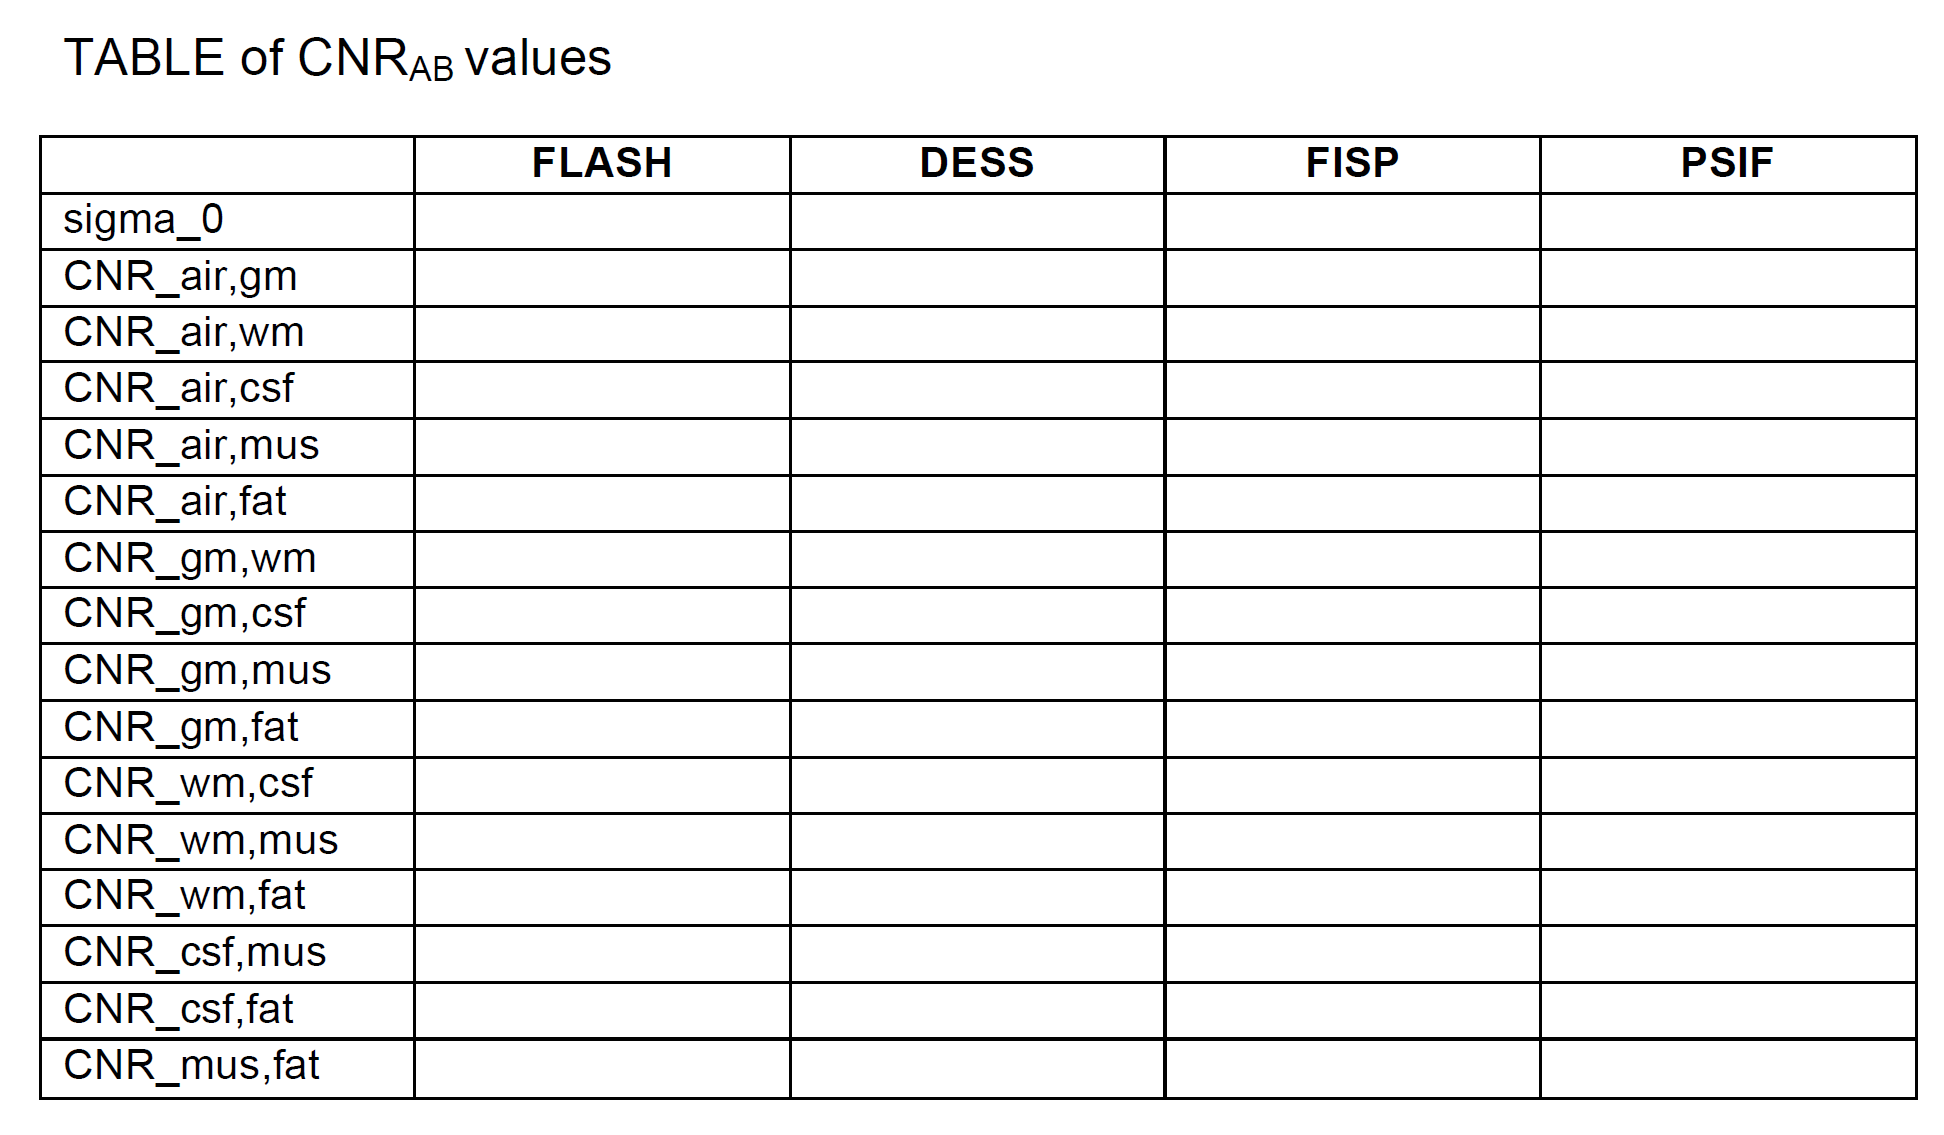

In [96]:
from IPython.display import Image
Image(filename='./assets/multispectral_mri_cnr_table.png', width=600)

- For which pair of tissue classes and in which channel do we find the largest contrast-to-noise ratio?

- Which channel expresses the smallest noise level (as we have previously defined `image noise`)? 

_(The brain mask (ROI mask) has not been actively used in this session, and we will come back to it's use in the next part dealing with **tissue classification** using machine learning methods)_